# Recommendations with IBM



## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Conclusions](#conclusions)

### Importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle
import seaborn as sns
import warnings
import re

from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.metrics import recall_score, f1_score

warnings.filterwarnings('ignore')

%matplotlib inline


In [2]:
df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Get an idea of user-item-interation data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [3]:
# Get an idea of the article content data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>



`1.` Take a look at the distribution of how many articles a user interacts with in the dataset.

In [4]:
# article counts for each user
df_article_times = pd.DataFrame(df[['email','article_id']].groupby(['email']).agg(['count']))
df_article_times.columns = [df_article_times.columns[0][1]]
df_article_times.head()

,count
email,
0000b6387a0366322d7fbfc6434af145adf7fed1,13
001055fc0bb67f71e8fa17002342b256a30254cd,4
00148e4911c7e04eeff8def7bbbdaf1c59c2c621,3
001a852ecbd6cc12ab77a785efa137b2646505fe,6
001fc95b90da5c3cb12c501d201a915e4f093290,2


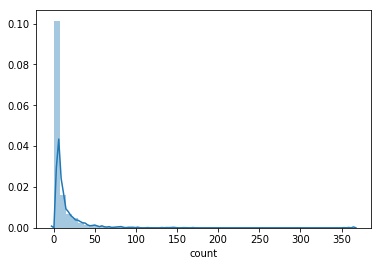

In [5]:
# plot the distribution of article interaction times
sns.distplot(df_article_times['count'])
plt.show()

In [6]:
# Find out the median and maximum numbers of user_article interactios
median_val = np.median(df_article_times['count'])# 50% of individuals interact with 3 number of articles or fewer.
max_views_by_user = np.max(df_article_times['count'])# The maximum number of user-article interactions by any 1 user is 364.

*** $Findings$
* Most individuals' article reading number is from 1 - 50.
  50% interact with 3 articles or fewer.
* The maximum number of user-article interactions is 364

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [7]:
# Take a look the shape of content dataframe
df_content.shape

(1056, 5)

In [8]:
# Take a look at all duplicated articles
df_content[df_content.duplicated(subset = ['article_id'], keep = False)].sort_values(['article_id'])

,doc_body,doc_description,doc_full_name,doc_status,article_id
50,Follow Sign in / Sign up Home About Insight Da...,Community Detection at Scale,Graph-based machine learning,Live,50
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
221,* United States\r\n\r\nIBM® * Site map\r\n\r\n...,When used to make sense of huge amounts of con...,How smart catalogs can turn the big data flood...,Live,221
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
232,Homepage Follow Sign in Get started Homepage *...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
399,Homepage Follow Sign in Get started * Home\r\n...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
578,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577


In [9]:
# Remove any rows that have the same article_id - only keep the first
df_content_uni = df_content.drop_duplicates(['article_id'], keep = 'first')
df_content_uni.shape

(1051, 5)

***$Findings$
* There are 5 dulicated artcles in the df_content dataset. Most due to doc description/body are different. 
* 1,051 articles are left in the content dataset after duplication.

`3.` Below cells would find out:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [10]:
# The number of unique articles that have an interaction with a user.
len(df['article_id'].unique())

714

In [11]:
# The number of unique articles in the dataset (whether they have any interactions or not
len(df_content['article_id'].unique())

1051

In [12]:
# The number of unique users in the dataset. (excluding null values)
len(df[df['email'].notnull()]['email'].unique())

5148

In [13]:
# The number of user-article interactions in the dataset.
len(df[df['email'].notnull()].drop_duplicates(['email','article_id']))

33669

In [14]:
# The number of user-article interactions in the dataset.
df.shape[0]

45993

In [15]:
unique_articles = 714# The number of unique articles that have at least one interaction
total_articles = 1051# The number of unique articles on the IBM platform
unique_users = 5148# The number of unique users
user_article_interactions = 45993# The number of user-article interactions

`4.` Find out the most viewed **article_id**, as well as how often it was viewed.  

In [16]:
pd.DataFrame(df[['article_id','email']].groupby(['article_id']).agg('count')\
             .sort_values(by=['email'], ascending = False)).head(1)

,email
article_id,
1429.0,937


In [17]:
most_viewed_article_id = '1429.0' 
max_views = 937

In [18]:
# Map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [19]:

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

We don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can only be based on how often an article was interacted with.

`1.` Find the **n** top articles ordered with most interactions as the top.

In [20]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    
    # get article interation records
    
    article_inter = df.groupby(['title']).agg('count')
    
    top_articles = pd.DataFrame(article_inter.sort_values(['user_id'], ascending = False)).head(n).index.tolist()
    
    return top_articles # Return the top article titles from df (not df_content)


def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    article_inter = df.groupby(['article_id']).agg('count')
    
    top_articles = pd.DataFrame(article_inter.sort_values(['user_id'], ascending = False)).head(n).index.tolist()
 
    return top_articles # Return the top article ids

In [21]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [22]:
# Test function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 



In [23]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # create an assistant column
    
    df['dum_value'] = 1
    
    # create pivot table, user_id as row and article_id as column
    user_item = pd.pivot_table(df,values = 'dum_value', index = 'user_id', columns = 'article_id')
    
    # fill NaN values as 0s
    user_item = user_item.fillna(0)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [24]:
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Find similar users function to take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar). Self-user will be excluded. Dot product will be used to compute similarity of two users. 

In [25]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered user list from highest similarty to lowest.
    
    '''
    # compute similarity of each user to the provided user
    user_dot = pd.DataFrame(np.dot(user_item, np.transpose(user_item)))[user_id-1]

    # sort by similarity
    user_dot = user_dot.sort_values(ascending = False)
    
    # create list of just the ids
    simi_user_ids = np.array(user_dot.index + 1)

    # remove the own user's id
    most_similar_users = [i for i in simi_user_ids if i != user_id]   
        
    return most_similar_users # return a list of the users in order from most to least similar
        

In [26]:
# Spot check of the function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Find articles from similar users to recommend for target user.  

In [27]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    
    article_names = df[df['article_id'].isin(article_ids)]['title'].unique().tolist()
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''

    article_ids = user_item.loc[user_id][user_item.loc[user_id] > 0].index.astype('str').values.tolist()
    article_names = get_article_names(article_ids, df=df)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # get articles the given user has seen
    has_seen_ids, has_seen_names = get_user_articles(user_id,user_item=user_item)
    
    # find similar users rank by similarites
    simi_users = find_similar_users(user_id, user_item=user_item)
    
    # initialize recs
    recs = []
    
    # loop similar users find the articles they read
    for u in simi_users:
        
        simi_ids,simi_names = get_user_articles(u,user_item=user_item)
        
        new_rec_ids = [ rec_id for rec_id in simi_ids if rec_id not in (has_seen_ids + recs)]
        
        recs = recs + new_rec_ids
        
        
        if len(recs) >= m:
            recs = recs[:m]
            break
    
    
    return recs # return recommendations for this user_id    

In [28]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'timeseries data analysis of iot events by using jupyter notebook',
 'graph-based machine learning',
 'using brunel in ipython/jupyter notebooks',
 'experience iot with coursera',
 'the 3 kinds of context: machine learning and the art of the frame',
 'deep forest: towards an alternative to deep neural networks',
 'this week in data science (april 18, 2017)',
 'higher-order logistic regression for large datasets',
 'using machine learning to predict parking difficulty']

In [29]:
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [30]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # similar user list
    simi_users = pd.DataFrame(pd.DataFrame(np.dot(user_item, np.transpose(user_item)))[user_id-1])
    simi_users.index = simi_users.index + 1
    
    # get num_interations
    num_of_article  = pd.DataFrame(df[['user_id','article_id']].groupby(['user_id']).agg('count')) 
    
    # join inter num with user similarities
    neighbors_df = simi_users.join(num_of_article)
    neighbors_df['neighbor_id'] = neighbors_df.index
    
    # rename columns
    neighbors_df.columns = ['similarity','num_interactions','neighbor_id']
    
    # filter out self
    neighbors_df = neighbors_df[neighbors_df['neighbor_id'] != user_id]
    
    # sort by similarity first, then by interact number
    neighbors_df = neighbors_df.sort_values(['similarity','num_interactions'], ascending = False).reset_index(drop = True)
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # get articles the given user has seen
    has_seen_ids, has_seen_names = get_user_articles(user_id,user_item=user_item)
    
    # find similar users rank by similarites
    neighbors_df = get_top_sorted_users(user_id, df=df, user_item=user_item)
    
    # initialize recs
    recs = []
    
    # loop similar users find the articles they read
    for u in neighbors_df['neighbor_id'].tolist():
        
        simi_ids,simi_names = get_user_articles(u,user_item=user_item)
        
        # filter out has seen ids and already in recs
        new_rec_ids = [ rec_id for rec_id in simi_ids if rec_id not in (has_seen_ids + recs)]

                
        # append new recs from this neighbor to already exist one
        recs = recs + new_rec_ids
        
        
                
        reads_by_user  = pd.DataFrame(df[['user_id','article_id']].groupby(['article_id']).agg('count')) 
        reads_by_user.columns = ['user_reads_num']  
     
        # sort by interaction with user    
        recs_ids_sort = reads_by_user[reads_by_user.index.isin(recs)]\
                           .sort_values(['user_reads_num'], ascending = False).index.tolist()
        
        # cut off at m recommendations
        if len(recs_ids_sort) >= m:
            recs = recs_ids_sort[:m]
            break
            
    # get article names
    rec_names = get_article_names(recs)
        
    return recs, rec_names

In [31]:
user_user_recs_part2(20,10)

([1330.0,
  1427.0,
  1364.0,
  1170.0,
  1162.0,
  1304.0,
  1351.0,
  1160.0,
  1354.0,
  1368.0],
 ['apache spark lab, part 1: basic concepts',
  'predicting churn with the spss random tree algorithm',
  'analyze energy consumption in buildings',
  'use xgboost, scikit-learn & ibm watson machine learning apis',
  'putting a human face on machine learning',
  'gosales transactions for logistic regression model',
  'insights from new york car accident reports',
  'model bike sharing data with spss',
  'analyze accident reports on amazon emr spark',
  'movie recommender system with spark machine learning'])

In [32]:
# Quick spot check 
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[1330.0, 1427.0, 1364.0, 1170.0, 1162.0, 1304.0, 1351.0, 1160.0, 1354.0, 1368.0]

The top 10 recommendations for user 20 are the following article names:
['apache spark lab, part 1: basic concepts', 'predicting churn with the spss random tree algorithm', 'analyze energy consumption in buildings', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'putting a human face on machine learning', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'model bike sharing data with spss', 'analyze accident reports on amazon emr spark', 'movie recommender system with spark machine learning']


`5.` Use your functions to fill in the solutions. 

In [33]:
### Tests with a dictionary of results
user1_most_sim = 3933# Find the user that is most similar to user 1 
user131_10th_sim = 242# Find the 10th most similar user to user 131

In [34]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` Make recommendations to new users.


If a new user was given, rank based recommendation would be able to do recommedations. Since rank based recommendation is based upon the most iteracted numbers with current users. No matter who is the new user, recommendation would be the same. However, user-user collaborative filtering is based on the reading history of a user. Then similar users and the articles read by similar users would be found out upon the similarity. However, we have no history information of a new user. Thus, user-user collaborative filtering method is not suitable for a new user.

A better way to make recommendation is to combine the rank-based and user-user collaborative method together. Making recommendation to current user via collaborative method and using rank-based for a new user.

`7.` Provide the top 10 recommended articles for a new user.

In [35]:
new_user = '0.0'

# Provide a list of the top 10 article ids you would give to new users who have no observed articles.
new_user_recs = get_top_article_ids(10)# Your recommendations here
new_user_recs = [str(i) for i in new_user_recs]
new_user_recs

['1429.0',
 '1330.0',
 '1431.0',
 '1427.0',
 '1364.0',
 '1314.0',
 '1293.0',
 '1170.0',
 '1162.0',
 '1304.0']

In [36]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations </a>


### Use article titles as the content base to do NLP and tf-idf transformation for getting a article content matrix. Then use this matrix to calculate article-article similarities.

In [37]:
# Define tokenize function 

def tokenize(text):
    """
    
    INPUT:
        text (str)

    OUTPUT:
        text_lems: list of element of the text after normalization, tokenization
        stopwords removal and lemmetization.
        
    DESCRIPTION:
        Nomalize, tokenize and lemmatize process for text
        
    """
    # Normailization -- lower case + remove puntuation
    text = re.sub(r"[^a-zA-Z0-9]"," ",text.lower())

    # tokenization
    tokens = word_tokenize(text)

    # Remove stop words
    words = [word for word in tokens if word not in stopwords.words("english")]

    # stemmization
    text_lems = [WordNetLemmatizer().lemmatize(lem).strip() for lem in words]

    return text_lems


In [38]:
# Build Text processing pipeline

tfidf_pip = Pipeline([
                ('vect', CountVectorizer(tokenizer = tokenize)),
                ('tfidf', TfidfTransformer())
            ])

In [39]:
# check if df_content covers all article ids which users have viewed in df

ttl_artiles = len(set(df['article_id'].values.tolist() + df_content_uni['article_id'].values.tolist())) 
ttl_article_content = len(df_content_uni['article_id'].values.tolist())

print("The number of total articles in article content table is {} less than total content and user have read".\
      format(ttl_artiles - ttl_article_content))

The number of total articles in article content table is 277 less than total content and user have read


** Thoughts: Found out content table doesn't contain all articles, there are **277** articles in viewed table but not in content table. Next step is to combine all unique articles together
1. Find article ids and names in viewed table but not in content table
2. Combine content table's and step 1's articles together to do text processing and get ti-idf transformation.

In [40]:
# create a function to generate total articles

def get_total_articles(df_view=df, df_article_content=df_content_uni):
    """    
    INPUT: 
    df_view (dataframe) - the user article table
    df_article_content (dataframe) - the article content unique table
    
    OUTPUT:
    df_total_articles(dataframe) - total unique article id and titles
    
    DESCRIPTION:
    To merge all article ids and titles from the article-user interation table and the article 
    content table together into one dataframe.
    """

    # Find unique articles in viewership table 
    view_articles = df_view['article_id'].unique()

    # Find unique articles in content table 
    content_articles = df_article_content['article_id'].unique()

    # Find the article in viewership table but not in content table
    diff_articles = [arti_id for arti_id in view_articles if arti_id not in content_articles]

    # Find diff unique article titles and ids
    df_diff_articles = df_view[df_view['article_id'].isin(diff_articles)][['article_id','title']].drop_duplicates()

    # Combine diff articles and content articles together
    df_content_articles = df_article_content[['article_id','doc_full_name']]
    df_content_articles.columns = ['article_id','title']

    df_total_articles = df_content_articles.append(df_diff_articles).reset_index(drop = True)    
    
    return df_total_articles

df_total_articles = get_total_articles()

In [41]:
# Fit and transform doc full name to tf-idf
doc_desc_tfidf = tfidf_pip.fit_transform(df_total_articles['title'].values).toarray()

# calculate movies' similarities by using dot production
dot_doc_names = doc_desc_tfidf.dot(np.transpose(doc_desc_tfidf))

In [42]:
def sorted_similar_articles(article_id, df_ttl_article=df_total_articles, dot_doc_names=dot_doc_names):
    """
    
    INPUT: 
    article_id - (int) an article id
    df_ttl_article - (dataframe) the combinated articles of title and id.
    dot_doc_names - (matrix) article names tfidf dot production.
    
    OUTPUT:
    df_article_similarities - (dataframe) article ids and corresponded similarty score of target article
    
    DESCRIPTION:
    Find similar articles based on doc titles content similarities.
    """
    
    # get article index of sepcific id
    article_idx = np.where(df_ttl_article['article_id'] == article_id)[0][0]
    
    # get sorted article indics from low to high
    similar_article_idxs = np.argsort(dot_doc_names[article_idx])
    
    # get sorted article ids upon sorted article indexs
    sorted_similar_article_ids = df_ttl_article.ix[similar_article_idxs]['article_id'].values
    
    # get similar scores
    sorted_similar_scores = dot_doc_names[article_idx][similar_article_idxs]
    
    # combine ids and scores into a dataframe
    df_article_similarities = pd.DataFrame({'article_id':sorted_similar_article_ids,\
                                            'article_scores_'+ str(article_id):sorted_similar_scores})
    
    return df_article_similarities

**Content Recs logics:**

1. get user viewed article ids
2. get similar articles to viewed articles -- combine score together to get an average score then take the highest
3. sort by viewer #s and get top articles
4. if avg score is same then based upon most viewed articles


In [43]:
def make_content_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    DESCRIPTION:
    Recommend the similar articles to current users upon their view history.
    Sort similarity first, if same then sort by article popularity.
    '''
    # for each viewed articles find the required # articles
    viewed_articles = df[df['user_id'] == user_id]['article_id'].values

    i = 1
    for article_id in viewed_articles:

        if i == 1:
            df_score = sorted_similar_articles(article_id)

        else:
            df_score = df_score.merge(sorted_similar_articles(article_id), on = ['article_id'], how = 'left')

        i += 1
        
    # get average similarity score of all target articles        
    df_score['avg_similarity_score'] = df_score.ix[:, 1:].mean(axis = 1)

    # get user read num
    reads_by_user  = pd.DataFrame(df[['user_id','article_id']].groupby(['article_id']).agg('count')) 
    reads_by_user.columns = ['user_reads_num']  
    reads_by_user['article_id'] = reads_by_user.index

    # join with score table
    df_score_readnum = df_score.merge(reads_by_user, on = ['article_id'],how = 'left').fillna(0)

    # sort avg scores, if same then sort by read num
    df_score_readnum = df_score_readnum.sort_values( by = ['avg_similarity_score','user_reads_num'], ascending = False).reset_index(drop = True)

    # join with df_score_readnum get title
    df_score_readnum = df_score_readnum.merge(df_total_articles, on = ['article_id'],how = 'left')

    # keep positive scores records
    df_score_pos = df_score_readnum[df_score_readnum['avg_similarity_score']>0]

    # remove view articles and keep top 10 recs
    recs = [art for art in df_score_pos['article_id'].values if art not in viewed_articles][:m]
    
    # get article names
    rec_names = df_score_readnum[df_score_readnum['article_id'].isin(recs)]['title'].values.tolist()
        
    return recs, rec_names

In [44]:
make_content_recs(24, 10)

([124.0, 313.0, 80.0, 521.0, 809.0, 1297.0, 122.0, 762.0, 437.0, 500.0],
 ['Python Machine Learning: Scikit-Learn Tutorial',
  'What is machine learning?',
  'Leverage Scikit-Learn Models with Core ML',
  'Learn about Data Science in World of Watson',
  'Use the Machine Learning Library',
  'from local spark mllib model to cloud with watson machine learning',
  'Watson Machine Learning for Developers',
  'From Machine Learning to Learning Machine (Dinesh Nirmal)',
  'IBM Watson Machine Learning: Get Started',
  'The Difference Between AI, Machine Learning, and Deep Learning?'])

`2.` Summary about how the content based recommender works and possible improvements that could be made.

** In genral this content-based recommendation system utilize article names to identify the similarities between articles. Based on similarities to find most similar articles for recommending. Detail steps as follows:

1. Find out the unique articles (ids and titles) from both user article interaction table and article content table.    Function `get_total_articles` could finish this step.
2. Do text processing on article titles, such as normalization, tokenization and lemmetization.
3. Apply tf-idf transformation on processed article titles to get a doc articles ti-idf matrix. 
4. Dot production on articles ti-idf matrix and its transpose for getting the similarities of article pairs.
5. For a given article id, function `sorted_similar_articles` could return a dataframe with article id along with the    similarity score with target article.
6. Finally, function `make_content_recs` could use article similities to recommend articles to target user.
   * Find out the viewed articles of this user.
   * For each viewed article, get the similarities with all articles.
   * Comnine all viewed articles' similarity scores together to get the average similarities.
   * Sort articles by average similarites, if similarities are same then sort by viewed user numbers.
   * Exclude already articles and get the target # recommendations from sorting high to low.
   
   
** Possible improvement:
1. Integrate the situation -- recommend for new users based upon content into the `make_content_recs`. Ideas are find the most popular article and find the most similar articles.
2. Deduplicate total same articles which just have different format titles.

** Novel about my content based recommendar:
1. Works for new articles which are never been viewed by users before. Collobartive filtering couldn't handle this situation.
2. Involves text processing into similarity calculation.
3. Also, integrate similarity and popularity together to make recommendation.

`3.` make recommendations for a brand new user.  


Thoughts: 
1. Find the Top 3 popular articles (For covering differnt perspective popularities) 
2. Get simility scores for the top 3 popular articles.
3. Get average simirities of all articles for these 3 articles.
4. Recommend target number articles based upon the similarities and popularities (include these top 3 articles)


In [45]:
def content_rec_to_new(m=10):
    
    """
    INPUT: m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    DESCRIPTION:
    Recommend top 3 popular articles along with their most similar articles to new users.
    """
    
    ## get top 3 popular articles
    # get user read num
    reads_by_user  = pd.DataFrame(df[['user_id','article_id']].groupby(['article_id']).agg('count')) 
    reads_by_user.columns = ['user_reads_num']  
    reads_by_user['article_id'] = reads_by_user.index
    top_3_artids = reads_by_user.sort_values(['user_reads_num'], ascending = False)['article_id'].values[:3]
    
    ## find articles' similarities
    i = 1
    for article_id in top_3_artids:

        if i == 1:
            df_score = sorted_similar_articles(article_id)

        else:
            df_score = df_score.merge(sorted_similar_articles(article_id), on = ['article_id'], how = 'left')

        i += 1

    # get average similarity score of all target articles        
    df_score['avg_similarity_score'] = df_score.ix[:, 1:].mean(axis = 1)

    # join with score table
    df_score_readnum = df_score.merge(reads_by_user, on = ['article_id'],how = 'left').fillna(0)

    # sort avg scores, if same then sort by read num
    df_score_readnum = df_score_readnum.sort_values( by = ['avg_similarity_score','user_reads_num'], ascending = False).reset_index(drop = True)

    # join with df_score_readnum get title
    df_score_readnum = df_score_readnum.merge(df_total_articles, on = ['article_id'],how = 'left')

    # keep positive scores records
    df_score_pos = df_score_readnum[df_score_readnum['avg_similarity_score']>0]

    # remove view articles and keep top 10 recs
    recs = df_score_pos['article_id'].values[:m]
    
    # get article names
    rec_names = df_score_readnum[df_score_readnum['article_id'].isin(recs)]['title'].values.tolist()
        
    return recs, rec_names        

In [46]:
content_rec_to_new(10)

(array([1330., 1431., 1429., 1181., 1403.,  754., 1432.,  381.,  299.,
        1160.]),
 ['insights from new york car accident reports',
  'visualize car data with brunel',
  'use deep learning for image classification',
  'car performance data',
  'uci: car evaluation',
  'Move a toy car with your mind',
  'visualize data with the matplotlib library',
  'A Classification Problem',
  'Brunel In Jupyter',
  'analyze accident reports on amazon emr spark'])

In [47]:
# make a recommendations for a user who only has interacted with article id '1427.0'

# get sorted articles' similarity to article '1427.0'
rec_ids_1427 = sorted_similar_articles(1427)[-11:-1]['article_id'].values
# get names
rec_names_1427 = df_total_articles[df_total_articles['article_id'].isin(rec_ids_1427)]['title'].values

print("Top 10 similar articles to 1427, ids are : {}".format(rec_ids_1427))
print("Ariticle names are: {}".format(rec_names_1427))

Top 10 similar articles to 1427, ids are : [  80. 1298.  122.  437.  161.  893. 1175.  313.  809.  124.]
Ariticle names are: ['Leverage Scikit-Learn Models with Core ML'
 'Watson Machine Learning for Developers'
 'Python Machine Learning: Scikit-Learn Tutorial'
 'Use the Machine Learning Library in Spark' 'What is machine learning?'
 'IBM Watson Machine Learning: Get Started'
 'Use the Machine Learning Library'
 'Use the Machine Learning Library in IBM Analytics for Apache Spark'
 'breast cancer detection with xgboost, wml and scikit'
 'from scikit-learn model to cloud with wml client']


In [48]:
## Put all together -- To new user + To only given article id + To only given user id

def make_content_recs2(new_user=False, article_id=None, user_id=None, m=10):
    '''
    INPUT:
    new_user - (boolean): define the function to a brand new user or not.
    article_id - (float): the target article id for finding similar recommendations with it.
    user_id - (int) a user id, if given, to recommend similar articles with what this user has read before.
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description: Content recommender to situation brand new user / only given articel id / only given user id

    '''
    
        
    # get user read num -- this part will be needed for the 3 situations
    reads_by_user  = pd.DataFrame(df[['user_id','article_id']].groupby(['article_id']).agg('count')) 
    reads_by_user.columns = ['user_reads_num']  
    reads_by_user['article_id'] = reads_by_user.index
    
    
    ### No matter what situation, the only difference is target articles are different. 
    
    ## Find target articles begins
    
    # New user situation:
    if new_user == True:
        ## get target articles
        target_artid = list(reads_by_user.sort_values(['user_reads_num'], ascending = False)['article_id'].values[:3])
    
    else:
        # only given article id:
        if article_id != None:
            target_artid = [article_id]
            
        else:
            # only given user id:
            # for each viewed articles find the required # articles
            target_artid = list(df[df['user_id'] == user_id]['article_id'].values)
    
    ## Find target articles ends
                

    # find articles' similarities with target articles
    i = 1
    for art_id in target_artid:

        if i == 1:
            df_score = sorted_similar_articles(art_id)

        else:
            df_score = df_score.merge(sorted_similar_articles(art_id), on = ['article_id'], how = 'left')

        i += 1

    # get average similarity score of all target articles        
    df_score['avg_similarity_score'] = df_score.ix[:, 1:].mean(axis = 1)

    # join with score table
    df_score_readnum = df_score.merge(reads_by_user, on = ['article_id'],how = 'left').fillna(0)

    # sort avg scores, if same then sort by read num
    df_score_readnum = df_score_readnum.sort_values( by = ['avg_similarity_score','user_reads_num'], ascending = False).reset_index(drop = True)

    # join with df_score_readnum get title
    df_score_readnum = df_score_readnum.merge(df_total_articles, on = ['article_id'],how = 'left')

    # keep positive scores records
    df_score_pos = df_score_readnum[df_score_readnum['avg_similarity_score']>0]
    
    # if for new user, then no need to remove target articles. Otherwise, need to remove them(it).
    if new_user == True:
        recs = df_score_pos['article_id'].values[:m].tolist()
    
    else: 
        # remove view articles and keep top 10 recs
        recs = [art for art in df_score_pos['article_id'].values if art not in target_artid][:m]
       
    # get article names
    rec_names = df_score_readnum[df_score_readnum['article_id'].isin(recs)]['title'].values.tolist()
        
    return recs, rec_names      

In [49]:
# Rerun above situations

# to new user
make_content_recs2(new_user=True, m=10)

([1330.0, 1431.0, 1429.0, 1181.0, 1403.0, 754.0, 1432.0, 381.0, 299.0, 1160.0],
 ['insights from new york car accident reports',
  'visualize car data with brunel',
  'use deep learning for image classification',
  'car performance data',
  'uci: car evaluation',
  'Move a toy car with your mind',
  'visualize data with the matplotlib library',
  'A Classification Problem',
  'Brunel In Jupyter',
  'analyze accident reports on amazon emr spark'])

In [50]:
# to given id 
make_content_recs2(article_id=1427, m=10)

([124.0, 809.0, 313.0, 1175.0, 893.0, 161.0, 437.0, 122.0, 1298.0, 80.0],
 ['Python Machine Learning: Scikit-Learn Tutorial',
  'Use the Machine Learning Library',
  'What is machine learning?',
  'breast cancer detection with xgboost, wml and scikit',
  'Use the Machine Learning Library in IBM Analytics for Apache Spark',
  'Use the Machine Learning Library in Spark',
  'IBM Watson Machine Learning: Get Started',
  'Watson Machine Learning for Developers',
  'from scikit-learn model to cloud with wml client',
  'Leverage Scikit-Learn Models with Core ML'])

In [51]:
# to target user
make_content_recs2(user_id=24, m=10)

([124.0, 313.0, 80.0, 521.0, 809.0, 1297.0, 122.0, 762.0, 437.0, 500.0],
 ['Python Machine Learning: Scikit-Learn Tutorial',
  'What is machine learning?',
  'Leverage Scikit-Learn Models with Core ML',
  'Learn about Data Science in World of Watson',
  'Use the Machine Learning Library',
  'from local spark mllib model to cloud with watson machine learning',
  'Watson Machine Learning for Developers',
  'From Machine Learning to Learning Machine (Dinesh Nirmal)',
  'IBM Watson Machine Learning: Get Started',
  'The Difference Between AI, Machine Learning, and Deep Learning?'])

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

`1.` Load **user_item** matrix above in **question 1** of **Part III** above. 

In [52]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [53]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
user_item_matrix.shape

(5149, 714)

`2.` Use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  

In [55]:
# Perform SVD on the User-Item Matrix Here
u, s, vt = np.linalg.svd(user_item_matrix)

In [56]:
# take a look at the SVD compositions
u.shape, s.shape, vt.shape

((5149, 5149), (714,), (714, 714))

SVD works on this case since each user - article pair has a 'rating' (view/not view) value there. That's because we assgined 0s to the user-aritlce matrix if a user hasn't seen this article. In other words, there is no missing value in user_item_matrix for this case. In prior lessons, if user has no rating for a movie then the cell value would be missing, which is the case SVD couldn't work on and need Funk SVD instead.

`3.` Choose the number of latent features.

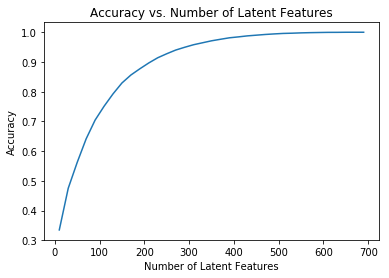

In [57]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [58]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    test_idx  = user_item_test.index.values
    test_arts = user_item_test.columns.values
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [59]:
# users in test user-item matrix also in train user-item matrix -- users could be predicted via SVD method
u_test_u_train = np.array([u for u in user_item_test.index.values if u in user_item_train.index.values])
len(u_test_u_train)

20

In [60]:
# articles in test user-item matrix also in train user-item matrix -- articles could be predicted via SVD method
a_test_a_train = np.array([a for a in user_item_test.columns.values if a in user_item_train.columns.values])
len(a_test_a_train)

574

In [61]:
# users couldn't be predicted since cold start
len(test_idx) - len(u_test_u_train)

662

In [62]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many articles can we make predictions for in the test set?': b,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d# letter here
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.


In [63]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)
u_train.shape, s_train.shape, vt_train.shape

((4487, 4487), (714,), (714, 714))

In [64]:
# get indics of rows and columns in train dataset
test_pred_index= np.asanyarray([np.where(user_item_train.index == idx)[0][0] for idx in u_test_u_train])
test_pred_artis = np.asanyarray([np.where(user_item_train.columns == idx)[0][0] for idx in a_test_a_train])

In [65]:
# 1s' ratio in the predictable test records -- only about 2%
user_item_test.ix[u_test_u_train,a_test_a_train].values.sum()/(20*574.0)

0.018989547038327528

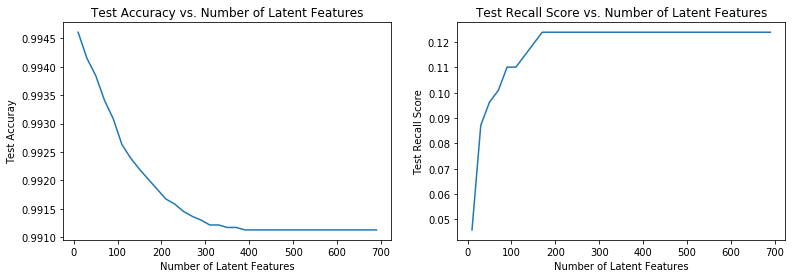

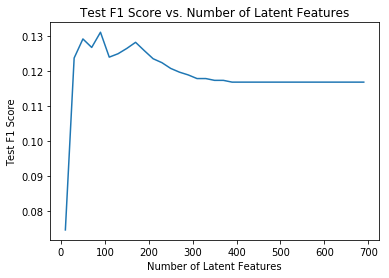

In [66]:
# Find the best letent feature numbers by evaluating the predicted performance on test subset.
# Since the distribution of view/not view is extremly imbalanced, so I will include 3 metrics for evaluation 
# -- Accuracy + Recall Score + F1 Score

num_latent_feats = np.arange(10,700+10,20)

sum_errs_test = []
recall_list = []
f1_score_list = []

for k in num_latent_feats:
    
    # restucture with k letent features
    s_train_new, u_train_new, vt_train_new = np.diag(s_train[:k]), u_train[:,:k], vt_train[:k,:]
    
    # take dot product
    test_item_est = np.around(np.dot(np.dot(u_train_new[test_pred_index,:], s_train_new), vt_train_new[:,test_pred_artis]))
    
    # get the true values of these 20 predicable test records
    user_item_test_pred_true = user_item_test.ix[u_test_u_train,a_test_a_train].values
    
    # compute error for each prediction of available test records to actual value
    test_diffs = np.subtract(user_item_test_pred_true, test_item_est)
    
    # total errors
    test_err = np.sum(np.sum(np.abs(test_diffs)))
    sum_errs_test.append(test_err)
    recall_list.append(recall_score(user_item_test_pred_true.ravel(), test_item_est.ravel()))
    f1_score_list.append(f1_score(user_item_test_pred_true.ravel(), test_item_est.ravel()))

    
plt.figure(figsize=(20,4))
    
plt.subplot(131)    
plt.plot(num_latent_feats, 1- np.array(sum_errs_test)/df.shape[0])
plt.xlabel('Number of Latent Features')
plt.ylabel('Test Accuray')
plt.title('Test Accuracy vs. Number of Latent Features')


plt.subplot(132)
plt.plot(num_latent_feats, recall_list)
plt.xlabel('Number of Latent Features')
plt.ylabel('Test Recall Score')
plt.title('Test Recall Score vs. Number of Latent Features')
plt.show()

plt.figure(figsize=(20,4))
plt.subplot(133)
plt.plot(num_latent_feats, f1_score_list)
plt.xlabel('Number of Latent Features')
plt.ylabel('Test F1 Score')
plt.title('Test F1 Score vs. Number of Latent Features')
plt.show()

`6.` Summary and Possible Validation Way about the recommendation system

* As the above charts showed, test accuracy was always high (>99%) no matter how many latent features we use. However, since the data is extremely imbalanced, high accuracy score doesn't mean a good prediction performance. Recall score and F1 score both showed that the SVD model performance wasn't good. 200 latent features would be a good choice for current model by considering both recall score and F1 score.



* I might do online A/B testing by randomly assigning current users/visitors into equally into test and control groups (Or take a small portion group users/visitor as this online A/B testing base insteading of using all traffics). Test group will receive article recommendations upon the recommendation systems built above. Control group won't receive recommendations which is how users currently find articles. Upon population size and generall article click rate to set testing length. After the testing period, compare two groups' article click #s, click rates and article reading time length(hours/minutes). Base upon results to see if any significant difference between applying the recommendation system and not using and how much of the impacts.

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])